## Import the necessary modules

In [1]:
from pycocotools.coco import COCO
import numpy as np
from tqdm import tqdm
import skimage.io as io
import json
import copy
import random
import os
import zipfile
import splitfolders as sp
import cv2
from PIL import Image, ImageEnhance

### For visualizing the outputs ###
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

## Set the output folders

In [3]:
# Based on the output folder of IOU Filtering
baseDirectory = 'Dataset'
dataDir=os.path.join('..', baseDirectory, 'images')
annFile=os.path.join('..', baseDirectory, 'annotations.json')

# Output directories where annotation file will be copied
outputAnnDir = "../" + baseDirectory + '/sharpened/' 
# Output directory where sharpened images will be placed
outputDir = "../" + baseDirectory + '/sharpened/images'  

os.makedirs(outputDir, exist_ok=True)

## Sharpen the images

In [4]:
# Iterate over the images in the base directory
for i in os.listdir(dataDir):
    image_file = i
    if image_file.split('.')[1] != 'json':
        image = Image.open(os.path.join(dataDir,image_file))                                                                    

        # Sharpen each image
        enhancer = ImageEnhance.Sharpness(image.convert('RGB'))
        image_sharp_3 = enhancer.enhance(1) 
        # Save sharpened image to output directory
        image_sharp_3.save(os.path.join(outputDir,image_file))

In [5]:
# Check the number of sharpened images
print(len(os.listdir(outputDir)))

207


In [6]:
# Copy over the annotation file from base directory
with open(annFile, "r") as read_file:
    annJson = json.load(read_file)
    
with open(os.path.join(outputAnnDir, "annotation.json"), "w") as write_file:
    json.dump(annJson, write_file)   

## Import the annotation file

In [7]:
# Directory of the orignal dataset
dataDir=outputDir
annFile= os.path.join(outputAnnDir,'annotation.json')

In [8]:
def createDataset(annFile, classes=None, mode='train'):    
    # initialize COCO api for instance annotations
    coco = COCO(annFile)
    
    images = coco.getImgIds()
    images = coco.loadImgs(images)

    # Now, filter out the repeated images
    unique_images = []
    for i in range(len(images)):
        if images[i] not in unique_images:
            unique_images.append(images[i])
            
    random.shuffle(unique_images)
    dataset_size = len(unique_images)
    print('Images Found: {}'.format(len(unique_images)))
    return unique_images, dataset_size, coco

In [9]:
# Split the images found in the coco annotations file 
images, dataset_size, coco = createDataset(annFile)

loading annotations into memory...
Done (t=0.15s)
creating index...
index created!
Images Found: 207


## Perform Train-test-split on the images

In [10]:
# Generate train/test/split folders 
folderToSplit = outputAnnDir
baseFolder = '../' + baseDirectory
trainFolder = os.path.join(baseFolder, 'train')
testFolder = os.path.join(baseFolder, 'test')
valFolder = os.path.join(baseFolder, 'val')

trainImages = os.path.join(trainFolder, 'images')
testImages = os.path.join(testFolder, 'images')
valImages = os.path.join(valFolder, 'images')

dirs = [baseFolder, trainFolder, testFolder, valFolder, trainImages, testImages, valImages]

for path in dirs: 
    os.makedirs(path, exist_ok=True)

In [11]:
# Perform train test split
tqdm(sp.ratio(folderToSplit, output=baseFolder, seed=1337, ratio=(0.6, 0.2, 0.2)))

Copying files: 207 files [00:00, 637.84 files/s]
0it [00:00, ?it/s]

In [12]:
# Create annotation files for each directory 
trainAnnDir = os.path.join(baseFolder, 'train', 'train.json')
valAnnDir = os.path.join(baseFolder, 'val', 'val.json')
testAnnDir = os.path.join(baseFolder, 'test', 'test.json')

trainRoofAnnDir = os.path.join(baseFolder, 'train', 'roof_train.json')
valRoofAnnDir = os.path.join(baseFolder, 'val', 'roof_val.json')
testRoofAnnDir = os.path.join(baseFolder, 'test', 'roof_test.json')

trainSSAnnDir = os.path.join(baseFolder, 'train', 'ss_train.json')
valSSAnnDir = os.path.join(baseFolder, 'val', 'ss_val.json') 
testSSAnnDir = os.path.join(baseFolder, 'test', 'ss_test.json')

# Print length of each folder 
print("Train: ", len(os.listdir(trainImages)))
print("Test: ", len(os.listdir(testImages)))
print("Val: ", len(os.listdir(valImages)))

Train:  124
Test:  42
Val:  41


## Copy contents of annotation file into respective folders

In [13]:
# Read the source annotation file 
with open(annFile, "r") as read_file:
    annJson = json.load(read_file)

In [14]:
annJson.keys()

dict_keys(['info', 'licenses', 'categories', 'images', 'annotations'])

In [15]:
# Create a base json where we copy info, licenses, and categories
baseJson = {}
baseJson['info'] = annJson['info']
baseJson['licenses'] = annJson['licenses']
baseJson['categories'] = []
baseJson['images'] = []
baseJson['annotations'] = []

In [16]:
roof_only = []
# Remap category IDs (since no superstructure)
for category in annJson['categories']:
    temp_cat = copy.deepcopy(category)
    temp_cat['id'] -= 1
    if (temp_cat['id'] != 0):
        roof_only.append(temp_cat)

In [17]:
for i in roof_only:
    print(i)

{'id': 1, 'name': 'FLAT', 'supercategory': ''}
{'id': 2, 'name': 'WNW', 'supercategory': ''}
{'id': 3, 'name': 'N', 'supercategory': ''}
{'id': 4, 'name': 'NNW', 'supercategory': ''}
{'id': 5, 'name': 'NW', 'supercategory': ''}
{'id': 6, 'name': 'W', 'supercategory': ''}
{'id': 7, 'name': 'WSW', 'supercategory': ''}
{'id': 8, 'name': 'SW', 'supercategory': ''}
{'id': 9, 'name': 'SSW', 'supercategory': ''}
{'id': 10, 'name': 'S', 'supercategory': ''}
{'id': 11, 'name': 'SSE', 'supercategory': ''}
{'id': 12, 'name': 'SE', 'supercategory': ''}
{'id': 13, 'name': 'ESE', 'supercategory': ''}
{'id': 14, 'name': 'E', 'supercategory': ''}
{'id': 15, 'name': 'ENE', 'supercategory': ''}
{'id': 16, 'name': 'NE', 'supercategory': ''}
{'id': 17, 'name': 'NNE', 'supercategory': ''}


In [18]:
ss_only = [annJson['categories'][0]]
ss_only

[{'id': 1, 'name': 'Superstructure', 'supercategory': ''}]

### TEST JSONS

In [19]:
# Create train, test, val JSONs based on the images inside each folder
# TEST JSON
testAnnJson = copy.deepcopy(baseJson)

testAnnJson['categories'] = annJson['categories']

# Create test folder json 
for imageFile in os.listdir(testImages):
    # Retrieve the corresponding COCO image obj for each file name
    for image in annJson['images']:
        if imageFile == image['file_name']:
            testAnnJson['images'].append(image)
            # Retrieve the annotations belonging to that image obj
            for annotation in annJson['annotations']: 
                # include all rooftop and superstructure annotations
                if image['id'] == annotation['image_id']: 
                    testAnnJson['annotations'].append(annotation)

In [20]:
# Create train, test, val JSONs based on the images inside each folder
# Roofs TEST JSON
testRoofAnnJson = copy.deepcopy(baseJson)

testRoofAnnJson['categories'] = roof_only

# Create test folder json 
for imageFile in os.listdir(testImages):
    # Retrieve the corresponding COCO image obj for each file name
    for image in annJson['images']:
        if imageFile == image['file_name']:
            testRoofAnnJson['images'].append(image)
            # Retrieve the annotations belonging to that image obj
            for annotation in annJson['annotations']: 
                # include all rooftop and superstructure annotations
#                 if image['id'] == annotation['image_id']: 
#                     testJson['annotations'].append(annotation)
                # only rooftop annotations
                if image['id'] == annotation['image_id'] and annotation['category_id'] != 1:
                    # Remap category IDs
                    temp_ann = copy.deepcopy(annotation)
                    temp_ann['category_id'] -= 1
                    testRoofAnnJson['annotations'].append(temp_ann)

In [21]:
# Superstructure TEST JSON
testSSAnnJson = copy.deepcopy(baseJson)

testSSAnnJson['categories'] = ss_only

# Create test folder json 
for imageFile in os.listdir(testImages):
    # Retrieve the corresponding COCO image obj for each file name
    for image in annJson['images']:
        if imageFile == image['file_name']:
            testSSAnnJson['images'].append(image)
            # Retrieve the annotations belonging to that image obj
            for annotation in annJson['annotations']:
                # only superstructure annotations
                if image['id'] == annotation['image_id'] and annotation['category_id'] == 1: 
                    testSSAnnJson['annotations'].append(annotation)

### VAL JSONS

In [22]:
# Create train, test, val JSONs based on the images inside each folder
# Roofs VAL JSON
valAnnJson = copy.deepcopy(baseJson)

valAnnJson['categories'] = annJson['categories']

# Create val folder json 
for imageFile in os.listdir(valImages):
    # Retrieve the corresponding COCO image obj for each file name
    for image in annJson['images']:
        if imageFile == image['file_name']:
            valAnnJson['images'].append(image)
            # Retrieve the annotations belonging to that image obj
            for annotation in annJson['annotations']: 
                # include all rooftop and superstructure annotations
                if image['id'] == annotation['image_id']: 
                    valAnnJson['annotations'].append(annotation)

In [23]:
# Create train, test, val JSONs based on the images inside each folder
# Roofs VAL JSON
valRoofAnnJson = copy.deepcopy(baseJson)

valRoofAnnJson['categories'] = roof_only

# Create val folder json 
for imageFile in os.listdir(valImages):
    # Retrieve the corresponding COCO image obj for each file name
    for image in annJson['images']:
        if imageFile == image['file_name']:
            valRoofAnnJson['images'].append(image)
            # Retrieve the annotations belonging to that image obj
            for annotation in annJson['annotations']: 
                # include all rooftop and superstructure annotations
#                 if image['id'] == annotation['image_id']: 
#                     valJson['annotations'].append(annotation)
                # only rooftop annotations
                if image['id'] == annotation['image_id'] and annotation['category_id'] != 1:
                    # Remap category IDs
                    temp_ann = copy.deepcopy(annotation)
                    temp_ann['category_id'] -= 1
                    valRoofAnnJson['annotations'].append(temp_ann)

In [24]:
# Superstructure VAL JSON
valSSAnnJson = copy.deepcopy(baseJson)

valSSAnnJson['categories'] = ss_only

# Create val folder json 
for imageFile in os.listdir(valImages):
    # Retrieve the corresponding COCO image obj for each file name
    for image in annJson['images']:
        if imageFile == image['file_name']:
            valSSAnnJson['images'].append(image)
            # Retrieve the annotations belonging to that image obj
            for annotation in annJson['annotations']:
                # only superstructure annotations
                if image['id'] == annotation['image_id'] and annotation['category_id'] == 1: 
                    valSSAnnJson['annotations'].append(annotation)

### TRAIN JSONS

In [25]:
# Create complete train json
trainAnnJson = copy.deepcopy(baseJson)

trainAnnJson['categories'] = annJson['categories']

# Create train folder json 
for imageFile in os.listdir(trainImages):
    # Retrieve the corresponding COCO image obj for each file name
    for image in annJson['images']:
        if imageFile == image['file_name']:
            trainAnnJson['images'].append(image)
            # Retrieve the annotations belonging to that image obj
            for annotation in annJson['annotations']: 
                # include all rooftop and superstructure annotations
                if image['id'] == annotation['image_id']: 
                    trainAnnJson['annotations'].append(annotation)

In [28]:
jsonFiles = [testRoofAnnJson, testSSAnnJson, valRoofAnnJson, valSSAnnJson]
# jsonFiles = [trainRoofAnnJson, trainSSAnnJson, testRoofAnnJson, testSSAnnJson, valRoofAnnJson, valSSAnnJson]

for item in jsonFiles:
    print(item['categories'])
    print()

[{'id': 1, 'name': 'FLAT', 'supercategory': ''}, {'id': 2, 'name': 'WNW', 'supercategory': ''}, {'id': 3, 'name': 'N', 'supercategory': ''}, {'id': 4, 'name': 'NNW', 'supercategory': ''}, {'id': 5, 'name': 'NW', 'supercategory': ''}, {'id': 6, 'name': 'W', 'supercategory': ''}, {'id': 7, 'name': 'WSW', 'supercategory': ''}, {'id': 8, 'name': 'SW', 'supercategory': ''}, {'id': 9, 'name': 'SSW', 'supercategory': ''}, {'id': 10, 'name': 'S', 'supercategory': ''}, {'id': 11, 'name': 'SSE', 'supercategory': ''}, {'id': 12, 'name': 'SE', 'supercategory': ''}, {'id': 13, 'name': 'ESE', 'supercategory': ''}, {'id': 14, 'name': 'E', 'supercategory': ''}, {'id': 15, 'name': 'ENE', 'supercategory': ''}, {'id': 16, 'name': 'NE', 'supercategory': ''}, {'id': 17, 'name': 'NNE', 'supercategory': ''}]

[{'id': 1, 'name': 'Superstructure', 'supercategory': ''}]

[{'id': 1, 'name': 'FLAT', 'supercategory': ''}, {'id': 2, 'name': 'WNW', 'supercategory': ''}, {'id': 3, 'name': 'N', 'supercategory': ''}, {

In [29]:
# Print length of each folder 
print("Train (Complete): ", len(trainAnnJson['images']))
print("Test (Complete): ", len(testAnnJson['images']))
print("Val (Complete): ", len(valAnnJson['images']))

print("ROOFS")
# print("Train: ", len(trainRoofAnnJson['images']))
print("Test: ", len(testRoofAnnJson['images']))
print("Val: ", len(valRoofAnnJson['images']))

print("SS")
# print("Train: ", len(trainSSAnnJson['images']))
print("Test: ", len(testSSAnnJson['images']))
print("Val: ", len(valSSAnnJson['images']))

Train (Complete):  124
Test (Complete):  42
Val (Complete):  41
ROOFS
Test:  42
Val:  41
SS
Test:  42
Val:  41


In [30]:
# WRITE ALL JSONS
with open(trainAnnDir, "w") as write_file:
    json.dump(trainAnnJson, write_file)
    
with open(valAnnDir, "w") as write_file:
    json.dump(valAnnJson, write_file)
    
with open(testAnnDir, "w") as write_file:
    json.dump(testAnnJson, write_file)

In [31]:
# WRITE ROOF JSONS
# with open(trainRoofAnnDir, "w") as write_file:
#     json.dump(trainRoofAnnJson, write_file)
    
with open(testRoofAnnDir, "w") as write_file:
    json.dump(testRoofAnnJson, write_file)
    
with open(valRoofAnnDir, "w") as write_file:
    json.dump(valRoofAnnJson, write_file)

In [32]:
# WRITE SS JSONS
# with open(trainSSAnnDir, "w") as write_file:
#     json.dump(trainSSAnnJson, write_file)
    
with open(testSSAnnDir, "w") as write_file:
    json.dump(testSSAnnJson, write_file)
    
with open(valSSAnnDir, "w") as write_file:
    json.dump(valSSAnnJson, write_file)

## Visualize the Train/Test/Val Folders (Optional)

In [33]:
# Visualize the test json
images, dataset_size, coco = createDataset(trainAnnDir)

loading annotations into memory...
Done (t=0.07s)
creating index...
index created!
Images Found: 124


Number of images containing all the  classes: 97


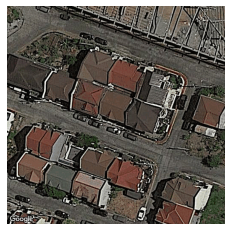

In [34]:
folderToPreview = trainImages

# Define the classes (out of the 81) which you want to see. Others will not be shown.
filterClasses = ['NNE']
# filterClasses = ['Superstructure']

# Fetch class IDs only corresponding to the filterClasses
catIds = coco.getCatIds(catNms=filterClasses) 
# Get all images containing the above Category IDs
imgIds = coco.getImgIds(catIds=catIds)
print("Number of images containing all the  classes:", len(imgIds))

# load and display a random image
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]

I = io.imread(folderToPreview + '/' + img['file_name'])/255.0

# annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIDs, iscrowd=None)
# anns = coco.loadAnns(annIds)
# coco.showAnns(anns)

plt.axis('off')
plt.imshow(I)
plt.show()

In [35]:
# Load in the classes inside the annotation file 
cats = coco.loadCats(coco.getCatIds())
catIDs = [i['id'] for i in cats]
classes = [cat['name'] for cat in cats]
# classes.remove('Superstructure')
print('COCO categories: \n{}\n'.format(' '.join(classes)))

COCO categories: 
Superstructure FLAT WNW N NNW NW W WSW SW SSW S SSE SE ESE E ENE NE NNE



In [36]:
catIDs

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]

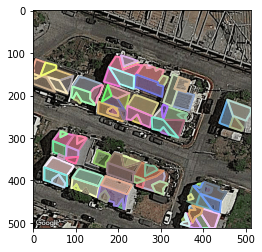

In [37]:
# Load and display instance annotations
plt.imshow(I)
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIDs, iscrowd=None)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)